# <center> New York City Taxi Trip Duration

<center> <img src='Images/image_for_readme_kaggle_project.png' width='800'/> </center>

# 1. Постановка задачи

Данная задача направленна на автоматизацию бизнес процессов. Построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представим, что мы заказываем такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько мы должны будем за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток мы совершаем нашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф!

Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для нас:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.

In [1]:
# Импорт библиотек для работы с данными и визуализации
import numpy as np  # Работа с массивами и числовыми вычислениями
import pandas as pd  # Работа с табличными данными (DataFrame)
import matplotlib.pyplot as plt  # Визуализация данных (основные графики)
import seaborn as sns  # Улучшенная визуализация (тепловые карты, плотности и т. д.)

# Импорт статистических и математических функций
from scipy import stats  # Статистические методы (тесты, распределения)

# Импорт библиотек машинного обучения из scikit-learn
from sklearn import linear_model  # Линейные модели (линейная, логистическая регрессия)
from sklearn import preprocessing  # Предобработка данных (нормализация, стандартизация)
from sklearn import model_selection  # Разделение выборки, кросс-валидация
from sklearn import tree  # Деревья решений
from sklearn import ensemble  # Ансамблевые методы (Random Forest, Gradient Boosting)
from sklearn import metrics  # Метрики для оценки моделей (MSE, MAE, R² и др.)
from sklearn import cluster  # Методы кластеризации (K-Means, DBSCAN и др.)
from sklearn import feature_selection  # Методы отбора признаков (например, SelectKBest)
from sklearn.pipeline import make_pipeline

from functions import add_datetime_features, add_holiday_features, add_osrm_features
from functions import add_geographical_features, add_cluster_features, add_weather_features
from functions import fill_null_weather_data, decision_normality

Прочитаем наш файл с исходными данными:

In [2]:
# Загружаем данные из CSV-файла в DataFrame
taxi_data = pd.read_csv("Data/train.csv")  

# Выводим размерность (количество строк и столбцов) загруженного DataFrame
print('Train data shape: {}'.format(taxi_data.shape))  

# Отображаем первые 5 строк загруженного датасета для ознакомления со структурой данных
display(taxi_data.head(10))

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Данные представлены следующими признаками:

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах

Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определим временные рамки (без учета времени), за которые представлены данные.

In [3]:
# Преобразование столбца pickup_datetime в формат datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Отображение минимальной даты (без учета времени)
display(f'Минимальная дата: {taxi_data["pickup_datetime"].min().date()}')
# Отображение максимальной даты (без учета времени)
display(f'Максимальная дата: {taxi_data["pickup_datetime"].max().date()}')

'Минимальная дата: 2016-01-01'

'Максимальная дата: 2016-06-30'

### 2.2
Посмотрим на пропуски.

In [4]:
print(f'Пропуски в датасете: {taxi_data.isnull().sum().sum()}')

Пропуски в датасете: 0


### 2.3
Посмотрим на статистические характеристики некоторых признаков:

а) Сколько уникальных таксопарков присутствует в данных.

б) Каково максимальное количество пассажиров.

в) Чему равна средняя и медианная длительность поездки.

г) Чему равно минимальное и максимальное время поездки (в секундах).


In [5]:
print(f'Количество уникальных таксопарков: {taxi_data["vendor_id"].nunique()}\n')
print(f'Максимальное количество пассажиров: {taxi_data["passenger_count"].max()}\n')
print(f'Средняя длительность поездки (в секундах): {round(taxi_data["trip_duration"].mean())}\n')
print(f'Медианная длительность поездки (в секундах): {round(taxi_data["trip_duration"].median())}\n')
print(f'Минимальное время поездки (в секундах): {round(taxi_data["trip_duration"].min())}\n')
print(f'Максимальное время поездки (в секундах): {round(taxi_data["trip_duration"].max())}')

Количество уникальных таксопарков: 2

Максимальное количество пассажиров: 9

Средняя длительность поездки (в секундах): 959

Медианная длительность поездки (в секундах): 662

Минимальное время поездки (в секундах): 1

Максимальное время поездки (в секундах): 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### 2.4
Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:

* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

Затем определим:

а) Сколько поездок было совершено в субботу;

б) Сколько поездок в среднем совершается в день.

In [6]:
# Применяем функцию к датасету
taxi_data = add_datetime_features(taxi_data)

# Маска суббота = 5
satuday_mask = taxi_data['pickup_day_of_week'] == 5

# Количество поездок, совершенных в субботу (день недели = 5)
print(f'Количество поездок в субботу: {taxi_data[satuday_mask].shape[0]}\n')
print(f'Среднее количество поездок в день: {round(taxi_data.shape[0] / taxi_data["pickup_date"].nunique())}')

Количество поездок в субботу: 0

Среднее количество поездок в день: 8015


### 2.5
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы:

* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

Далее возвращаем обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Затем проверим чему равна медианная длительность поездки на такси в праздничные дни.

In [7]:
# Загрузим датасет с праздниками в США в 2016 году
holiday_data = pd.read_csv('Data/holiday_data.csv')

# Создаем новый признак pickup_holiday
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Группируем по праздничным дням и считаем количество в секундах поздки
median_trip_duration = taxi_data.groupby(['pickup_holiday'])['trip_duration'].median()

# Медианная длительность поездок в праздничные дни в секундах
print(f'Медианная длительность поездки в праздничные дни: {round(median_trip_duration.loc[1])}')

Медианная длительность поездки в праздничные дни: 585


### 2.6
Примечание:
В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации!

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API.

__OSRM (Open Source Routing Machine)__ — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину. У данного сервиса есть API, которым можно воспользоваться.

Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

возвращаем обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

Проверим данные:
а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM.

В результате объединения таблиц у нас получаются пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц.

In [8]:
# Загружаем данные из полученные из OSRM API
osrm_data = pd.read_csv('Data/osrm_data_train.csv')

# Добавляем OSRM-признаки в taxi_data
taxi_data = add_osrm_features(taxi_data, osrm_data)

# Вычисляем разницу медианной длительности поездки
median_diff = abs(round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()))

# Вывод результатов
print(f'Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки из OSRM: {median_diff}\n')
print(f'Количество пропусков в столбцах с ифн. из OSRM API после объединения: {taxi_data.isnull().sum()}\n')

Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки из OSRM: 372

Количество пропусков в столбцах с ифн. из OSRM API после объединения: id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64



### 2.7.
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:

* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;

* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Проверим чему равно медианное расстояние Хаверсина поездок (в киллометрах).

In [9]:
# Применяем функцию
taxi_data = add_geographical_features(taxi_data)

# Проверяем медианное расстояние Хаверсина
median_haversine_distance = round(taxi_data['haversine_distance'].median(), 2)

# Проверяем результат
print(f'Медианное расстояние Хаверсина поездок в киллометрах: {median_haversine_distance}\n')

Медианное расстояние Хаверсина поездок в киллометрах: 2.09



### 2.8.
Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция вернет обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Проверим сколько поездок содержится в наименьшем по размеру географическом кластере.

In [10]:
# Создаем массив координат (только для ненулевых данных)
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# Обучаем KMeans только если его еще не обучали
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Добавляем кластеры в таблицу
taxi_data = add_cluster_features(taxi_data, kmeans)

# Проверяем, сколько поездок в каждом кластере
cluster_counts = taxi_data['geo_cluster'].value_counts()

# Находим минимальное количество поездок среди всех кластеров
count_of_min_cluster = cluster_counts.min()

# Выводим результат
display(f'Количество поездок в наименьшем по размеру кластере: {count_of_min_cluster}')

/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


'Количество поездок в наименьшем по размеру кластере: 2'

### 2.9.
Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

возвращаем обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:

* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

Проверим: 
а) Сколько поездок было совершено в снежную погоду.

В результате объединения у нас получились записи, для которых в столбцах temperature, visibility, wind speed, precip, и events есть пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями.

In [11]:
# Загружаем данные о погоде
weather_data = pd.read_csv('Data/weather_data.csv')

# Оставляем только нужные столбцы и переименовываем 'wind speed' -> 'wind_speed'
cols_to_keep = ['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']
weather_data = weather_data[cols_to_keep].rename(columns={'wind speed': 'wind_speed'})

# Приводим 'date' к формату datetime
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.date
# Приводим 'pickup_date' в taxi_data к формату date (без времени)
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date']).dt.date

# Создание новых признаков
taxi_data = add_weather_features(taxi_data, weather_data)

# Удаляем лишние признаки после объединения
taxi_data = taxi_data.drop(['date', 'hour'], axis=1)

# Подсчёт количества поездок в снежную погоду
snow_trip_counts = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print(f'Количетсво поездок в снежную погоду: {snow_trip_counts}\n')

# Подсчёт общего количества пропусков в столбцах с погодными условиями
weather_columns = ['temperature', 'visibility', 'wind_speed', 'precip', 'events']
# Количество строк, где ВСЕ погодные параметры отсутствуют
fully_missing_weather_rows = taxi_data[weather_columns].isnull().all(axis=1).sum()

# Общее количество строк
total_rows = taxi_data.shape[0]

# Доля строк, где отсутствуют абсолютно все погодные параметры
fully_missing_percentage = round((fully_missing_weather_rows / total_rows) * 100, 2)
print(f'Процент записей, где полностью отсутствуют погодные данные: {fully_missing_percentage}%')

Количетсво поездок в снежную погоду: 13126

Процент записей, где полностью отсутствуют погодные данные: 0.82%


### 2.10.
Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция заполнит пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполняются медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполняем пропуски. 

Пропуски в столбце events заполняем строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполняем медианным значением по столбцам.

Проверим чему равна медиана в столбце temperature после заполнения пропусков.

In [12]:
# Применяем функцию
taxi_data = fill_null_weather_data(taxi_data)

# Результат
print(f'Медиана в столбце temperature: {round(taxi_data["temperature"].median(), 1)}')

Медиана в столбце temperature: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Сложнее обстоят дела с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что выбросами будут считаться только последние группы, тут возникает вопрос как же их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:

$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$

Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:

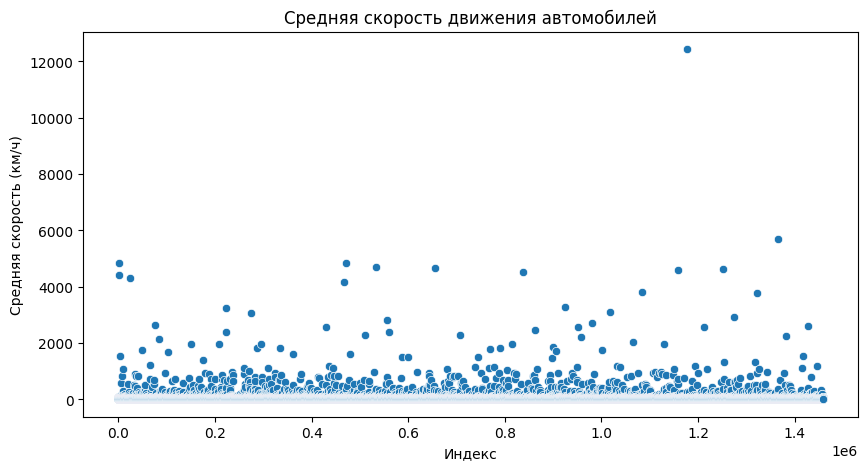

In [13]:
# Вычисляем среднюю скорость движения такси в км/ч
# 'total_distance' — общее расстояние поездки (обычно в километрах)
# 'trip_duration' — длительность поездки (обычно в секундах)
# Умножаем на 3.6, чтобы перевести из м/с в км/ч
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6  

# Создаём фигуру и координатные оси для построения графика
fig, ax = plt.subplots(figsize=(10, 5))  

# Строим диаграмму рассеяния, где:
# x — индекс поездки (номер строки в данных)
# y — рассчитанная средняя скорость
# ax — объект осей, куда будет добавлен график
sns.scatterplot(
    x=avg_speed.index,  
    y=avg_speed,  
    ax=ax  
)

# Устанавливаем заголовок графика
ax.set_title('Средняя скорость движения автомобилей')  

# Подписываем оси
ax.set_xlabel('Индекс')  
ax.set_ylabel('Средняя скорость (км/ч)')  

# Отображаем график
plt.show()

Из графика видно, что у в данных есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.

### 2.11.
Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

Проверим:
а) Сколько выбросов по признаку длительности поездки удалось найти.

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

Проверим:
б) Сколько выбросов по признаку скорости удалось найти.

In [14]:
# Найти поездки, длительность которых превышает 24 часа (86400 секунд)
long_trip_outliers = taxi_data[taxi_data['trip_duration'] > 86400]
num_long_trip_outliers = long_trip_outliers.shape[0]

# Удалить эти поездки из данных
taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]

# Вывести количество выбросов по длительности
print(f'Количество выбросов по длительности поездки: {num_long_trip_outliers}\n')

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

# Находим выбросы по скорости (больше 300 км/ч)
speed_outliers = taxi_data[taxi_data['avg_speed'] > 300]
num_speed_outliers = speed_outliers.shape[0]

# Удаляем выбросы по скорости
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]

# Выводим количество выбросов по скорости
print(f'Количество выбросов по средней скорости: {num_speed_outliers}')

Количество выбросов по длительности поездки: 4

Количество выбросов по средней скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части проекта будем:

* Исследовать сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним анализ визуализациями, иллюстрирующими, исследовани.

Начинем с целевого признака. Поскольку основной метрикой решения данной задачи является RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе, будем использовать именно его. 

В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:

$$trip\_duration\_log = log(trip\_duration+1),$$

где под символом log подразумевается натуральный логарифм.

In [15]:
# Прологорифмируем наш целевой признак
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### 3.1.
Построем гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным?

Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

Проверим:

а) Чему равен вычисленный p-value.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным.

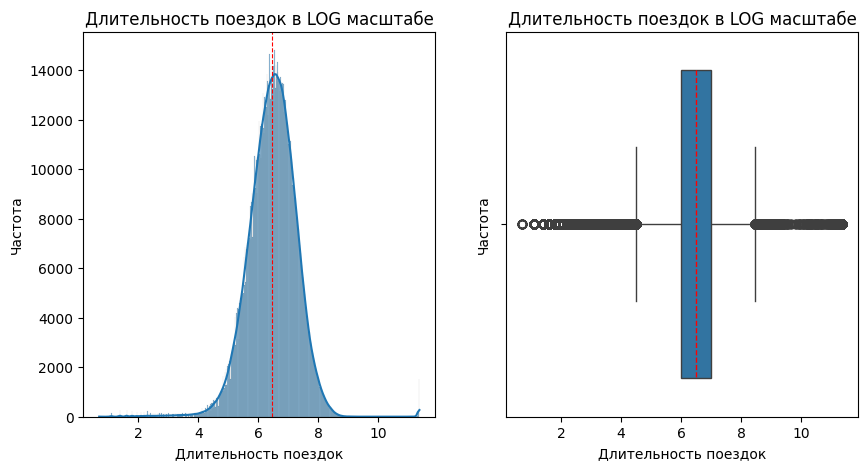

In [16]:
# Создание фигуры и двух осей для построения графиков
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# Гистограмма (Histogram) с KDE-графиком (плотность распределения)
sns.histplot(
    data=taxi_data['trip_duration_log'],  # Данные о логарифме длительности поездок
    kde=True,  # Добавляем сглаженную кривую плотности (Kernel Density Estimate)
    ax=axes[0]  # Размещаем график в первом подграфике (левый график)
)

# Устанавливаем заголовок и подписи осей для гистограммы
axes[0].set_title('Длительность поездок в LOG масштабе')
axes[0].set(xlabel='Длительность поездок', ylabel='Частота')

# Добавляем вертикальную линию на уровне среднего значения логарифма длительности поездок
axes[0].axvline(
    taxi_data['trip_duration_log'].mean(),  # Среднее значение
    color='red',  # Цвет линии
    linestyle='--',  # Тип линии — пунктирная
    linewidth=0.8  # Толщина линии
)

# Коробчатая диаграмма (Boxplot) для анализа выбросов и распределения
sns.boxplot(
    data=taxi_data['trip_duration_log'],  # Данные
    orient='h',  # Горизонтальное расположение коробчатой диаграммы
    medianprops={"color": "red", "linestyle": '--'},  # Оформление медианы (красная пунктирная линия)
    ax=axes[1]  # Размещаем график во втором подграфике (правый график)
)

# Устанавливаем заголовок и подписи осей для коробчатой диаграммы
axes[1].set_title('Длительность поездок в LOG масштабе')
axes[1].set(xlabel='Длительность поездок', ylabel='Частота')

# Отображаем оба графика
plt.show()

**Проверка на нормальность**

С помощью теста Д’Агостино и Пирсона проверяем, распределён ли признак нормально!

Гипотезы теста Д’Агостино и Пирсона:

* Нулевая гипотеза ($H_0$): распределение данные является нормальным.
* Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [17]:
# проводим Тест Д’Агостино и Пирсона
_, p = stats.normaltest(taxi_data['trip_duration_log'])
decision_normality(p)

p-value = 0.0

p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


# Вывод: 
Несмотря на то, что визуально мы имеем данные в форме колокола, что намекает на нормальное распределение, тесты проведенные с помощью Д’Агостино и Пирсона и дальнейшего сравнения с показателем альфа данные распределены отлично от нормального при условии, что мы логарифмируем признак длительности поездки.

### 3.2.
Построем визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравним два распределения между собой.

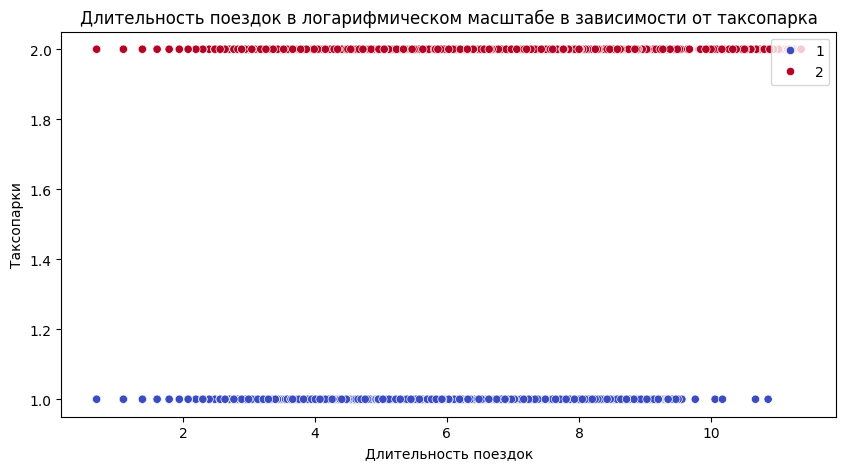

In [18]:
# figsize=(10, 5) — размер графика (ширина 10, высота 5 дюймов)
fig, axes = plt.subplots(figsize=(10, 5))  

# Строим диаграмму рассеяния (scatter plot)
sns.scatterplot(
    data=taxi_data,  # Исходные данные (DataFrame с поездками)
    x='trip_duration_log',  # Значения по оси X (логарифм длительности поездок)
    y='vendor_id',  # Значения по оси Y (ID таксопарка)
    hue='vendor_id',  # Цвет точек в зависимости от таксопарка
    palette='coolwarm',  # Цветовая палитра для визуального различия таксопарков
    ax=axes  # Используем оси, созданные ранее
)

# Устанавливаем заголовок графика
axes.set_title('Длительность поездок в логарифмическом масштабе в зависимости от таксопарка')

# Устанавливаем подписи осей X и Y
axes.set(xlabel='Длительность поездок', ylabel='Таксопарки')
axes.legend(loc="upper right") 

# Отображаем график
plt.show()

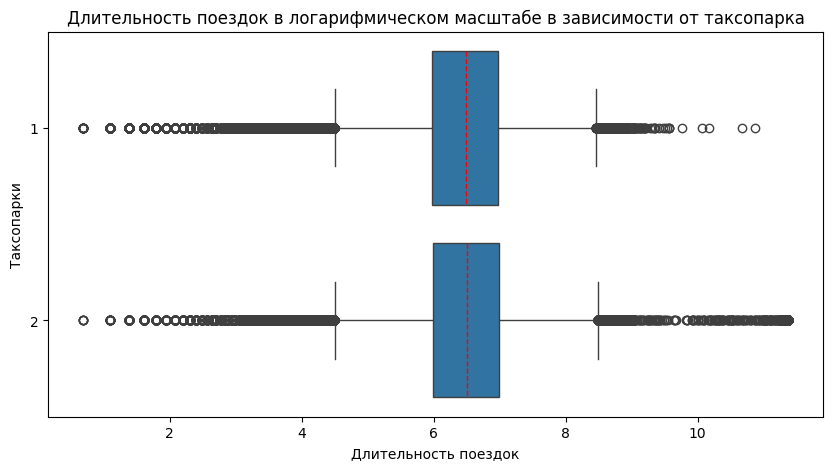

In [19]:
# figsize=(10, 5) — размер графика (ширина 10, высота 5 дюймов)
fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='vendor_id',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    ax=axes)

# Устанавливаем метки для осей X и Y графика
axes.set_title('Длительность поездок в логарифмическом масштабе в зависимости от таксопарка')
axes.set(xlabel='Длительность поездок', ylabel='Таксопарки')

plt.show()

# Вывод: 
Cогласно графикам мы имеем в данных всего два таксопарка и распределение в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### 3.3.
Построем визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравним два распределения между собой.

Примечание:

store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. 

- Y - хранить и пересылать, 
- N - не хранить и не пересылать поездку.

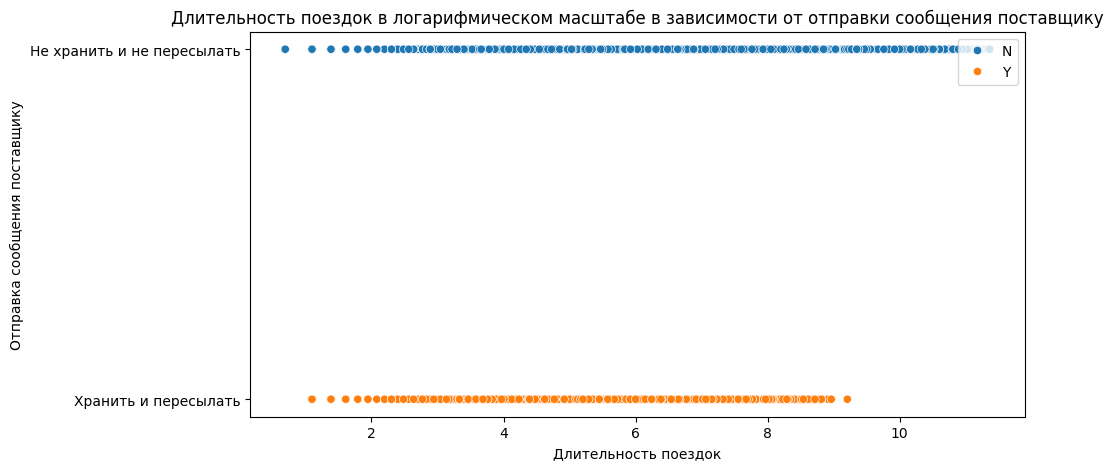

In [20]:
# figsize=(10, 5) — размер графика (ширина 10, высота 5 дюймов)
fig, axes = plt.subplots(figsize=(10, 5))

sns.scatterplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    hue='store_and_fwd_flag',
    ax=axes)

# Устанавливаем метки для осей X и Y графика
axes.set_title('Длительность поездок в логарифмическом масштабе в зависимости от отправки сообщения поставщику')
axes.set(xlabel='Длительность поездок', ylabel='Отправка сообщения поставщику')
axes.legend(loc="upper right")

# Указываем фиксированные тики перед их переименованием
axes.set_yticks([0, 1])  
axes.set_yticklabels(['Не хранить и не пересылать', 'Хранить и пересылать'])

plt.show()

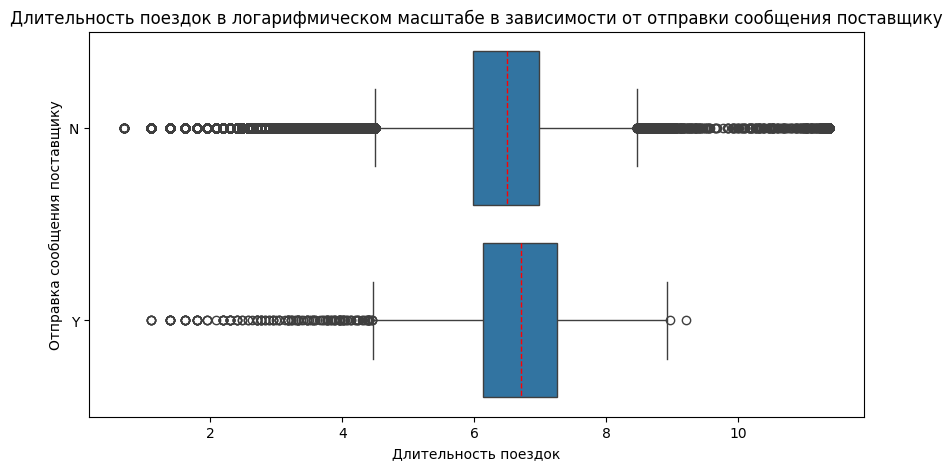

In [21]:
# figsize=(10, 5) — размер графика (ширина 10, высота 5 дюймов)
fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    ax=axes) # Строим коробчатую диаграмму на основе логарифмической шкалы времени поездок

# Устанавливаем метки для осей X и Y графика
axes.set_title('Длительность поездок в логарифмическом масштабе в зависимости от отправки сообщения поставщику')
axes.set(xlabel='Длительность поездок', ylabel='Отправка сообщения поставщику')

plt.show()

### 3.4.
Построем две визуализации:

* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков сделаем выводы:

а) В какое время суток такси заказывают реже всего.

б) В какое время суток наблюдается пик медианной длительности поездок.

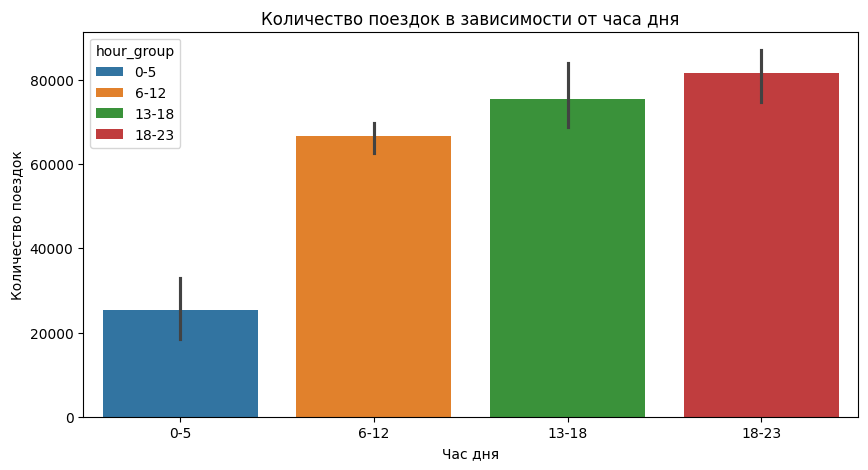

In [22]:
# Группируем данные по часам из столбца pickup_datetime
grouped_data = taxi_data.groupby(taxi_data['pickup_datetime'].dt.hour)['trip_duration'].count().reset_index()
# Создаем новую категориальную переменную "hour_group" (группы часов)
grouped_data['hour_group'] = pd.cut(
    grouped_data['pickup_datetime'],  # Исходный столбец (час)
    bins=[0,6,13,18,23],  # Границы групп (0-5, 6-12, 13-17, 18-22)
    labels=["0-5","6-12","13-18","18-23"]  # Названия групп
)
# Переименовываем колонку trip_duration в trips_count для лучшего понимания
grouped_data.rename(columns={'trip_duration': 'trips_count'}, inplace=True)

# Создаем фигуру для графика с размером (10, 5)
fig, axes = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=grouped_data,
    x='hour_group',
    y='trips_count',
    hue='hour_group',
    ax=axes)

# Устанавливаем метки для осей X и Y графика
axes.set_title('Количество поездок в зависимости от часа дня')
axes.set(xlabel='Час дня', ylabel='Количество поездок')

plt.show()

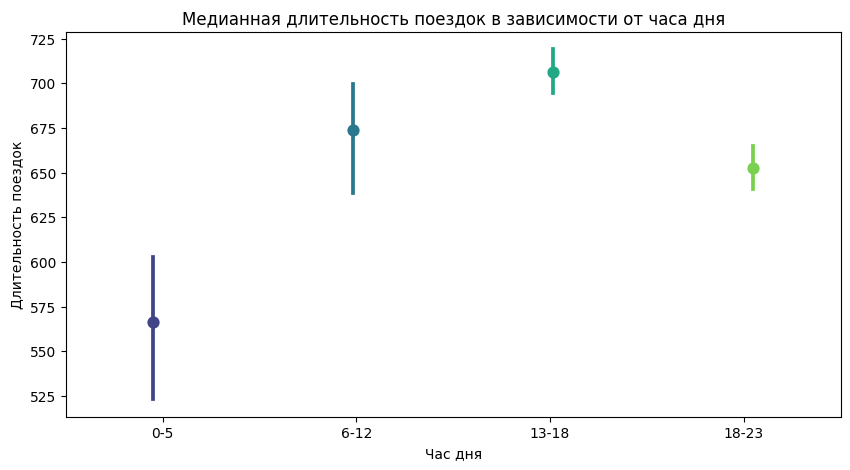

In [23]:
# Группируем данные по часам начала поездки и вычисляем медианную длительность поездок
grouped_data = taxi_data.groupby(taxi_data['pickup_datetime'].dt.hour)['trip_duration'].median().reset_index()
# Создаем новую категориальную переменную "hour_group" (группы часов)
grouped_data['hour_group'] = pd.cut(
    grouped_data['pickup_datetime'],  # Исходный столбец (час)
    bins=[0,6,13,18,23],  # Границы временных интервалов (0-5, 6-12, 13-17, 18-22)
    labels=["0-5","6-12","13-18","18-23"]  # Названия групп
)

fig, axes = plt.subplots(figsize=(10, 5))

sns.pointplot(
    data=grouped_data,
    x='hour_group',
    y='trip_duration',
    hue='hour_group',
    palette="viridis",
    legend=False,
    markers='o',  # Используем круги в качестве маркеров
    linestyles='-',  # Линии соединяют точки
    dodge=True,  # Разделяет точки, если есть пересечения
    ax=axes)

# Устанавливаем метки для осей X и Y графика
axes.set_title('Медианная длительность поездок в зависимости от часа дня')
axes.set(xlabel='Час дня', ylabel='Длительность поездок')

plt.show()

# Вывод:

На основе построенных графиков можно сказать, что с 00:00 до 5:00 утра наблюдается спад поездок, а согласно второму графику пик медианной длительности поездок наблюдается с 13:00 до 18:00.

### 3.5.
Пострем две визуализации:

* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков сделаем выводы:

а) В какой день недели совершается больше всего поездок.

б) В какой день недели медианная длительность поездок наименьшая.

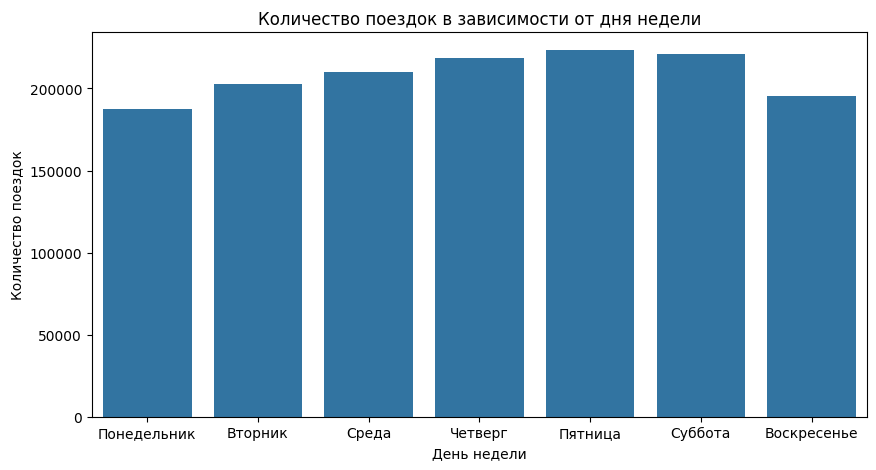

In [24]:
# Группируем данные по дню недели и считаем количество поездок
grouped_data = taxi_data.groupby(taxi_data['pickup_datetime'].dt.day_of_week)['trip_duration'].count().reset_index()
# Переименовываем столбцы для лучшего понимания
grouped_data.rename(columns={'pickup_datetime': 'day_of_week', 'trip_duration': 'trips_count'}, inplace=True)

# Создаем фигуру для графика
fig, axes = plt.subplots(figsize=(10, 5))

# Строим столбчатую диаграмму (barplot)
sns.barplot(
    data=grouped_data,
    x='day_of_week',  # Используем числовое представление дней недели (0-6)
    y='trips_count',
    ax=axes
)

# Устанавливаем заголовок и подписи осей
axes.set_title('Количество поездок в зависимости от дня недели')
axes.set(xlabel='День недели', ylabel='Количество поездок')

# Обновляем подписи оси X, чтобы показывать названия дней недели
axes.set_xticks(range(7))  # Устанавливаем правильное количество меток (0–6)
axes.set_xticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

# Отображаем график
plt.show()

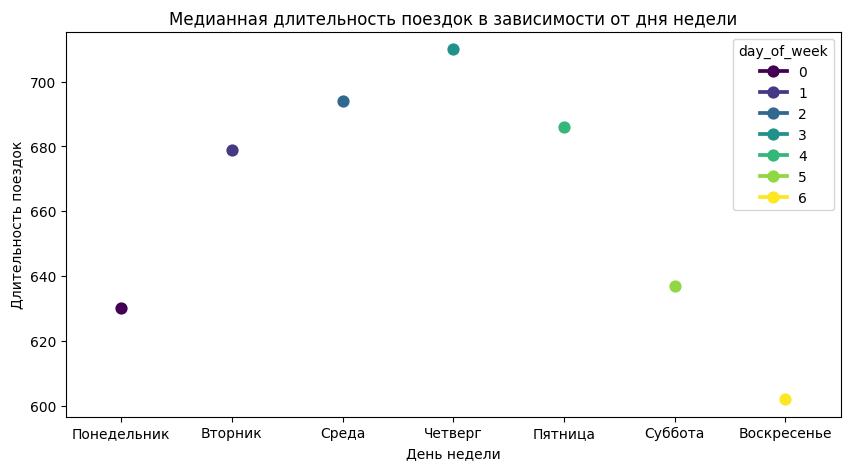

In [25]:
# Группируем данные по дню недели и вычисляем медианную длительность поездок
grouped_data = taxi_data.groupby(taxi_data['pickup_datetime'].dt.day_of_week)['trip_duration'].median().reset_index()
# Переименовываем столбец для лучшего понимания
grouped_data.rename(columns={'pickup_datetime': 'day_of_week'}, inplace=True)

# Создаем фигуру для графика
fig, axes = plt.subplots(figsize=(10, 5))

# Строим точечный график (pointplot) с обновленными параметрами
sns.pointplot(
    data=grouped_data,
    x='day_of_week',  # Ось X - день недели (0-6)
    y='trip_duration',  # Ось Y - медианная длительность поездок
    hue='day_of_week',  # Цветовая дифференциация точек по дням недели
    palette="viridis",  # Цветовая схема
    ax=axes
)

# Устанавливаем заголовок и подписи осей
axes.set_title('Медианная длительность поездок в зависимости от дня недели')
axes.set(xlabel='День недели', ylabel='Длительность поездок')

# Обновляем подписи оси X (0-6 → Названия дней недели)
axes.set_xticks(range(7))
axes.set_xticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

# Отображаем график
plt.show()

# Вывод:

На основе двух графиков можно сделать выводы, что больше всего совершается поездок в пятницу (первый график), а наименьшая медианная длительность поездок приходится на воскресенье.

### 3.6.
Посмотрим на обе временные характеристики одновременно.

Построем сводную таблицу (pivot_table), по строкам которой отложены часы (pickup_hour), по столбцам - дни недели(pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируем полученную сводную таблицу с помощью тепловой карты (используем палитру - coolwarm).

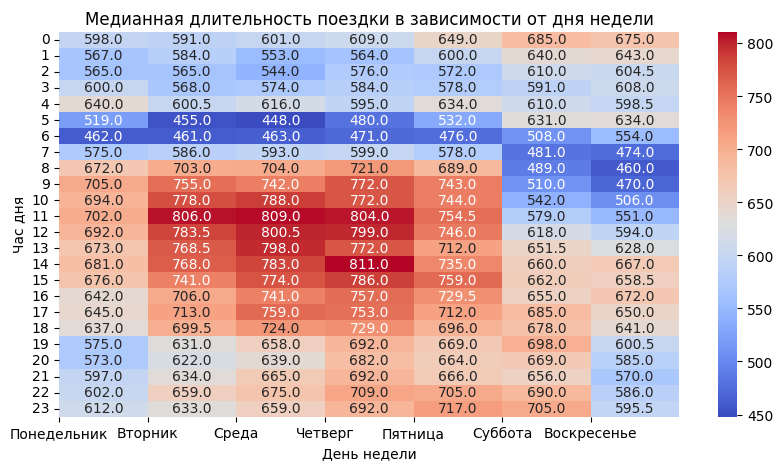

In [26]:
# Делаем копию датафрейма, чтобы не менять оригинальные данные
taxi_data_copy = taxi_data.copy()

# Выделяем час и день недели в отдельные столбцы
taxi_data_copy['pickup_hour'] = taxi_data_copy['pickup_datetime'].dt.hour
taxi_data_copy['pickup_day_of_week'] = taxi_data_copy['pickup_datetime'].dt.day_of_week

# Создаем сводную таблицу с медианной длительностью поездок
pivot_table = pd.pivot_table(
    taxi_data_copy, 
    values='trip_duration', 
    index='pickup_hour', 
    columns='pickup_day_of_week', 
    aggfunc='median'
)

# Создаем график
fig, axes = plt.subplots(figsize=(10, 5))

# Отображаем тепловую карту с аннотациями
sns.heatmap(
    data=pivot_table, 
    cmap='coolwarm',
    annot=True,  # Добавляем подписи значений внутри ячеек
    fmt=".1f"    # Формат чисел (один знак после запятой)
)

# Настройки осей и заголовков
axes.set_title('Медианная длительность поездки в зависимости от дня недели')
axes.set(xlabel='День недели', ylabel='Час дня')

# Указываем подписи дней недели
axes.set_xticks(range(7))
axes.set_xticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

# Отображаем график
plt.show()

# Вывод:
Из тепловой карты мы делаем следующие выводы, о том, что: 

- самые продолжительные поездки (в медианном смысле) наблюдались с понедельника по пятницу в промежутке с 8 до 18 часов.

- Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### 3.7.
Построем две диаграммы рассеяния (scatter-диаграммы):

* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые были сгенерированы ранее. 

Примечание: для наглядности уменьшиим размер точек на диаграмме рассеяния.

Кластеров в пределах города: 8
Кластеров за пределами города: 2


/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


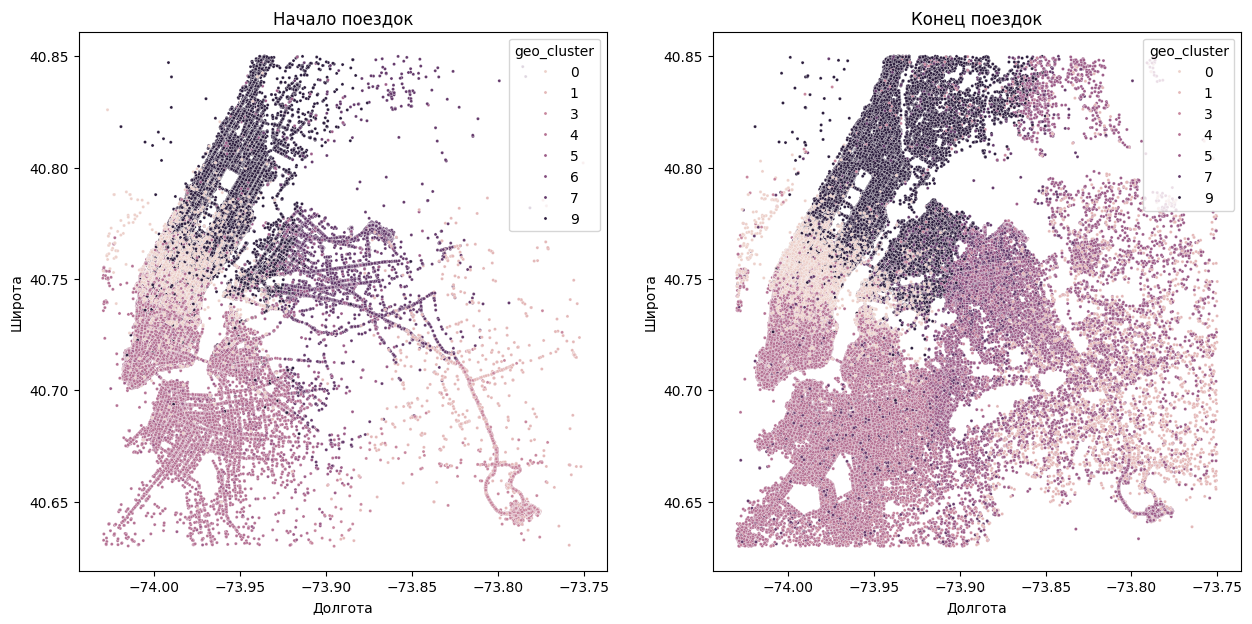

In [27]:
# Определяем границы города (долгота и широта), чтобы отфильтровать поездки в пределах города
city_long_border = (-74.03, -73.75)  # Границы долготы
city_lat_border = (40.63, 40.85)  # Границы широты

# Создаем фигуру с двумя графиками (две оси на одном холсте)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Две колонки графиков, размер 15x7 дюймов

# Фильтруем поездки, оставляя только те, что начинаются в пределах города
pickup_mask = (taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1]) & (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
# Фильтруем поездки, оставляя только те, что заканчиваются в пределах города
dropoff_mask = (taxi_data['dropoff_longitude'] >= city_long_border[0]) & (taxi_data['dropoff_longitude'] <= city_long_border[1]) & (taxi_data['dropoff_latitude'] >= city_lat_border[0]) & (taxi_data['dropoff_latitude'] <= city_lat_border[1])

# Подсчитываем количество уникальных географических кластеров в пределах города
all_clusters = taxi_data[pickup_mask]['geo_cluster'].nunique()

# Подсчитываем количество кластеров, которые выходят за пределы города
missing_clusters = taxi_data['geo_cluster'].nunique() - all_clusters

# Выводим информацию о кластерах
print(f'Кластеров в пределах города: {all_clusters}')
print(f'Кластеров за пределами города: {missing_clusters}')

# Визуализация начала поездок (pickup points)
sns.scatterplot(
    data=taxi_data[pickup_mask],  # Данные только в пределах города
    x='pickup_longitude', 
    y='pickup_latitude', 
    hue='geo_cluster',  # Раскрашиваем точки по географическим кластерам
    s=5,  # Размер точек
    legend='full',  # Полная легенда
    ax=axes[0]  # Размещаем график в первой колонке
)

# Настраиваем оси и заголовок для первого графика (начало поездок)
axes[0].set_title('Начало поездок')
axes[0].set(xlabel='Долгота', ylabel='Широта')

# Визуализация конца поездок (dropoff points)
sns.scatterplot(
    data=taxi_data[dropoff_mask],  # Данные только в пределах города
    x='dropoff_longitude', 
    y='dropoff_latitude', 
    hue='geo_cluster',  # Раскрашиваем точки по географическим кластерам
    s=5,  # Размер точек
    legend='full',  # Полная легенда
    ax=axes[1]  # Размещаем график во второй колонке
)

# Настраиваем оси и заголовок для второго графика (конец поездок)
axes[1].set_title('Конец поездок')
axes[1].set(xlabel='Долгота', ylabel='Широта')

# Отображаем график
plt.show()

# Вывод:

Таким образом мы определили отсутствующие кластеры, которые находятся за пределами города: 2, 8. Всего их оказалось 2.

## 4. Отбор и преобразование признаков (FeatureEngineering)

Перед тем как перейти к построению модели, осталось сделать ещё несколько манипуляций.

* Поскольку некоторые алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде, их необходим закодировать;
* Надо отобрать признаки, которые будут использоваться для обучения модели;
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

In [28]:
# Удаляем признак avg_speed, он лишний
taxi_data = taxi_data.drop(columns=['avg_speed'])

print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind_speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [29]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind_speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### 4.1.
Позаботимся об очевидных неинформативных и избыточных признаках.

Проверим:

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности.

б) Проверим данные на утечка данных (data leak).

в) Проверим, наличие какого из признаков в обучающем наборе данных создает утечку данных.

г) Исключим выбранные в пунктах признаки из исходной таблицы с данными и сделаем выводы сколько столбцов в таблице у вас осталос.

In [30]:
# Если число уникальных значений в столбце равно числу строк (1458233), значит, этот столбец уникальный.
unique_counts = taxi_data.nunique().sort_values(ascending=False)
print(unique_counts)

drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

id                    1458233
haversine_distance    1451907
direction             1451647
dropoff_datetime      1379993
pickup_datetime       1379849
total_distance         197214
dropoff_latitude        62503
pickup_latitude         45219
dropoff_longitude       33801
pickup_longitude        23014
total_travel_time       19438
trip_duration_log        7413
trip_duration            7413
pickup_date               182
temperature               124
number_of_steps            43
precip                     28
pickup_hour                24
wind_speed                 22
visibility                 17
passenger_count            10
geo_cluster                10
pickup_day_of_week          7
events                      4
vendor_id                   2
pickup_holiday              2
store_and_fwd_flag          2
dtype: int64
Shape of data:  (1458233, 25)


# Вывод:
Очевидно, что id является уникальны признаком для каждой поездки и не несет практической пользы для наших задач. Кроме того, в наших данных утечку создаёт признак dropoff_datetime — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:

In [31]:
# Удаляем ненужные признаки
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)

print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### 4.2.

Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

Проверим:

а) Cреднее по закодированному столбцу vendor_id.

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag

In [32]:
# Оба признака преобразовываются в бинарный формат (0/1)
# Кодирование vendor_id
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0.0 if x == 1.0 else 1)

# Кодирование store_and_fwd_flag
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0.0 if x == 'N' else 1.0)

# Вывод результатов
print(f"Среднее значение по закодированному столбцу vendor_id: {train_data['vendor_id'].mean():.2f}\n")
print(f"Среднее значение по закодированному столбцу store_and_fwd_flag: {train_data['store_and_fwd_flag'].mean():.3f}")

Среднее значение по закодированному столбцу vendor_id: 0.53

Среднее значение по закодированному столбцу store_and_fwd_flag: 0.006


Примечание: 

Следующие три признака (pickup_day_of_week, geo_cluster, events) являются номинальными. Поэтому для них отлично подойдёт однократное кодировани (OneHotEncoding).

### 4.3.
Создаем таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установим значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder мы получим безымянный numpy-массив, который необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных воспользуемся специальным методом get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

В результате выполнения кода мы получаем DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.

Проверим cколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования.

In [33]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объявляем кодировщик
encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')

# numpy-массив, полученный в результате трансформации кодировщиком
data_onehot = encoder.fit_transform(train_data[columns_to_change])

# Получаем закодированные имена столбцов
column_names = encoder.get_feature_names_out(columns_to_change)

# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)

print(f'Количество бинарных столбцов: {data_onehot.shape[1]}\n')

Количество бинарных столбцов: 18



Добавим полученную таблицу с закодированными признаками в основной датасет:

In [34]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], axis=1
)
print('Shape of data: {}\n'.format(train_data.shape))

Shape of data: (1458233, 38)



Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. 

В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:

In [35]:
# Формируем матрицу наблюдений X, исключая целевые признаки
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
# Формируем целевой вектор y
y = train_data['trip_duration']
# Формируем логарифмированную целевую переменную y_log
y_log = train_data['trip_duration_log']

Все модели будут обучаться на логарифмированной версии y_log.

Для разбиения данных воспользуемся стандартным способом. Тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [36]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,  # 33% данных идут в валидационную выборку, 67% в обучающую
    random_state=42  # Фиксируем разбиение для воспроизводимость
)

На данный момент образовалось достаточно много признаков и скорее всего, не все из них будут важны! Поэтому останутся лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели. Отберем такие признаки с помощью SelectKBest.

### 4.4.
С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Проверим какие признаки вошли в список отобранных.

In [37]:
# Создаем объект SelectKBest
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)

# Обучаем на данных
X_train_selected = selector.fit_transform(X_train, y_train_log)
X_valid_selected = selector.transform(X_valid)

# Получаем список отобранных признаков
selected_features = X_train.columns[selector.get_support()]

# Выводим список отобранных признаков
display(f"Выбранные признаки для тренировочной выборке: {selected_features}\n")
display(f"Количество признаков для тренировочной выборке: {len(selected_features)}")

"Выбранные признаки для тренировочной выборке: Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',\n       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',\n       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',\n       'number_of_steps', 'haversine_distance', 'temperature',\n       'pickup_day_of_week_Monday', 'pickup_day_of_week_Saturday',\n       'pickup_day_of_week_Sunday', 'pickup_day_of_week_Thursday',\n       'pickup_day_of_week_Tuesday', 'pickup_day_of_week_Wednesday',\n       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',\n       'geo_cluster_9'],\n      dtype='object')\n"

'Количество признаков для тренировочной выборке: 25'

Так как далее будут использоваться различные модели, в том числе внутри которых заложены численные методы оптимизации, то необходимо воспользоваться маштабированием данных.

### 4.5.
Нормализуем предикторы (признакми) в обучающей и валидационной выборках с помощью MinMaxScaler() из библиотеки sklearn. 

Примечание: обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитаем среднее арифметическое для первого предиктора (т.е. для первого столбца матрицы) из валидационной выборки.

In [38]:
# Объявляем нормализатор
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_selected)

# Обучаем нормализатор на обучающей выборке и трансформируем данные
X_train_scaled = scaler.transform(X_train_selected)
# Применяем ту же трансформацию к валидационной выборке
X_valid_scaled = scaler.transform(X_valid_selected)

# Рассчитываем среднее арифметическое первого предиктора в валидационной выборке
mean_first_feature = np.mean(X_valid_scaled[:, 0])

# Округляем результат до двух знаков после запятой
mean_rounded = round(mean_first_feature, 2)
print(f"Среднее первого предиктора (валидационная выборка): {mean_rounded}")

Среднее первого предиктора (валидационная выборка): 0.54


In [39]:
# Преобразуем массивы numpy обратно в DataFrame, чтобы сохранить названия признаков и индексы строк  
X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    columns=selected_features, 
    index=X_train.index,
    dtype='float64')

# Аналогично для валидационной выборки  
X_valid_scaled = pd.DataFrame(
    X_valid_scaled,
    columns=selected_features,
    index=X_valid.index,
    dtype='float64')

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой будем измеряться качество используемых моделей. Будем следовать правилам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$

где:

* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Поскольку логарифмирование целевого признака уже было сделано заранее, необходимо лишь вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:

$$z_i=log(y_i+1),$$

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$

### 5.1.
Построем модель линейной регрессии на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [40]:
# Инициализируем модель линейной регрессии
lr_model = linear_model.LinearRegression()

# Обучаем модель на нормализованных данных
lr_model.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей выборке
train_pred = lr_model.predict(X_train_scaled)
# Предсказания на валидационной выборке
valid_pred = lr_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.54
Метрика RMSLE для валидационной выборке: 0.54


### 5.2.
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures() из библиотеки sklearn. Параметр include_bias выставим в значение False.

Построем модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

Проверим:

а) Метрику RMSLE на тренировочной и валидационной выборках для полученной модели.

б) Наблюдаются ли модели признаки переобучения.

In [41]:
# Создаем пайплайн (в связке использования полиноминальных признаков и линейной регрессии)
poly_model = make_pipeline(
    preprocessing.PolynomialFeatures(degree=2, include_bias=False), 
    linear_model.LinearRegression())

# Обучаем модель
poly_model.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей выборке
train_pred = poly_model.predict(X_train_scaled)
# Предсказания на валидационной выборке
valid_pred = poly_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.47
Метрика RMSLE для валидационной выборке: 0.7


# Вывод:

Для данной модели наблюдается некоторый признак переобучения. Чтобы исправить ситуацию с перобучением, воспользуемся методами регуляризации.

### 5.3.
Построем модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). 

Коэффициент регуляризации $\alpha$ установим равным 1, остальные параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [42]:
# Преобразование признаков с помощью PolynomialFeatures (степень 2)
poly_model = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly_model.fit_transform(X_train_scaled)
X_test_poly = poly_model.fit_transform(X_valid_scaled)

# Создание модели полиномиальной регрессии с L2-регуляризацией (Ridge)
ridge_regressor = linear_model.Ridge(alpha=1.0)  # alpha — это коэффициент регуляризации

# Обучение модели
ridge_regressor.fit(X_train_poly, y_train_log)

# Прогнозирование
train_pred = ridge_regressor.predict(X_train_poly)
valid_pred = ridge_regressor.predict(X_test_poly)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.48
Метрика RMSLE для валидационной выборке: 0.48


### 5.4.
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию. 

Проверим:

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

б) Наблюдаются ли у вашей модели признаки переобучения.

In [43]:
# Создание модели Дерева решений без ограничения глубины
dt_model = tree.DecisionTreeRegressor(random_state=42)

# Обучаем модель на тренировочных данных
dt_model.fit(X_train_scaled, y_train_log)

# Прогнозирование
train_pred = dt_model.predict(X_train_scaled)
valid_pred = dt_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.0
Метрика RMSLE для валидационной выборке: 0.57


# Вывод:

Для данной модели наблюдается так же наблдюдается некоторый признак переобучения. Дело в том, что деревья решений без ограничения их глубины, как правило, всегда приводят к переобучению! Это важно помнить и чтобы исправить ситуацию с перобучением ограничим глубину деревьев решений.

### Задание 5.5.
Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

- max_depths = range(7, 20)

Параметр random_state зададим равным 42.

Построим линейные графики измерения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

Проверим:

а) Оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной.

Глубина дерева: 7
Метрика RMSLE для обучающей выборке: 0.44
Метрика RMSLE для валидационной выборке: 0.45
------------------------------------------------------------
Глубина дерева: 8
Метрика RMSLE для обучающей выборке: 0.44
Метрика RMSLE для валидационной выборке: 0.44
------------------------------------------------------------
Глубина дерева: 9
Метрика RMSLE для обучающей выборке: 0.43
Метрика RMSLE для валидационной выборке: 0.44
------------------------------------------------------------
Глубина дерева: 10
Метрика RMSLE для обучающей выборке: 0.42
Метрика RMSLE для валидационной выборке: 0.43
------------------------------------------------------------
Глубина дерева: 11
Метрика RMSLE для обучающей выборке: 0.41
Метрика RMSLE для валидационной выборке: 0.43
------------------------------------------------------------
Глубина дерева: 12
Метрика RMSLE для обучающей выборке: 0.41
Метрика RMSLE для валидационной выборке: 0.43
--------------------------------------------------------

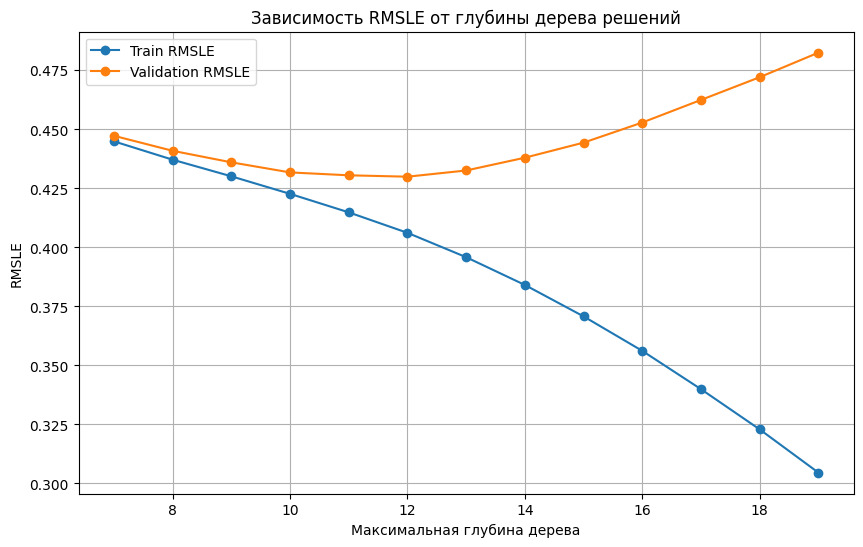

Оптимальная глубина дерева: 12


In [44]:
# Варианты глубин дерева
max_depths = range(7, 20)
train_errors = []
val_errors = []

# Цикл подбора глубин дерева решений
for depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train_scaled, y_train_log)

    # Предсказания
    train_pred = model.predict(X_train_scaled)
    valid_pred = model.predict(X_valid_scaled)

    # Рассчитываем RMSLE
    rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
    rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

    # Выводим результаты
    print(f'Глубина дерева: {depth}')
    print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
    print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')
    print('---' * 20)
    
    train_errors.append(rmsle_train)
    val_errors.append(rmsle_valid)

# Построение графика зависимости метрики от глубины дерева
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Train RMSLE', marker='o')
plt.plot(max_depths, val_errors, label='Validation RMSLE', marker='o')
plt.xlabel("Максимальная глубина дерева")
plt.ylabel("RMSLE")
plt.legend()
plt.title("Зависимость RMSLE от глубины дерева решений")
plt.grid(True)
plt.show()

# Вывод результата
optimal_depth = max_depths[np.argmin(val_errors)]
print(f"Оптимальная глубина дерева: {optimal_depth}")

Далее получить оптимальную глубину воспользуемся снова моделью уже с настроенной оптимальной глубиной.

In [45]:
# Создание модели Дерева решений с оптимальной глубиной определенной выше
dt_model = tree.DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)

# Обучаем модель на тренировочных данных
dt_model.fit(X_train_scaled, y_train_log)

# Прогнозирование
train_pred = dt_model.predict(X_train_scaled)
valid_pred = dt_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.41
Метрика RMSLE для валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Теперь попробуем воспользовать "тяжелой артиллерией": ансамблевым алгоритмам для улучшения метрик.

### 6.1.

Построем модель случайного леса на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажим следующие:

* n_estimators=200,
* max_depth=12, (наша лучшая глубина)
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [46]:
# Построение модели случайного леса с установками
rnd_forest_model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True
)

# Обучение модели на тренировочных данных
rnd_forest_model.fit(X_train_scaled, y_train_log)

# Прогнозирование
train_pred = rnd_forest_model.predict(X_train_scaled)
valid_pred = rnd_forest_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 24.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   22.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s


Метрика RMSLE для обучающей выборке: 0.4
Метрика RMSLE для валидационной выборке: 0.41


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.8s


# Вывод: 
Благодаря параллельному обучению нескольких деревьев модель случайного леса дала небольшой прирост качества по сравнению с обычным деревом решений в 0.02 единицы - неплохо.

Далее посмотрим, что будет при последовательном ансамблировании.

### 6.2.

Построем модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы нормализованы, целевую переменную используем в логарифмическом масштабе). 

В качестве гиперпараметров укажим следующие:

* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [47]:
# Построение градиентного бустинга
gbr_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)
# Обучение модели на тренировочных данных
gbr_model.fit(X_train_scaled, y_train_log)

# Прогнозирование
train_pred = gbr_model.predict(X_train_scaled)
valid_pred = gbr_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, valid_pred))

# Выводим результаты
print(f'Метрика RMSLE для обучающей выборке: {round(rmsle_train, 2)}')
print(f'Метрика RMSLE для валидационной выборке: {round(rmsle_valid, 2)}')

Метрика RMSLE для обучающей выборке: 0.37
Метрика RMSLE для валидационной выборке: 0.39


# Вывод:
Таким образом согласно результатам построения нескольких моделей выяснялось, что наилучшую метрику (RMSLE) показала модель градиентного бустинга над деревьями решений - 0.39! Эта модель на данный момент лучше всего справилась с валидационными данными.

### 6.3.
Построем столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажим топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

/var/folders/0g/dcvscgwn2bx5ldpwsnftw38c0000gn/T/ipykernel_99763/1259225363.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


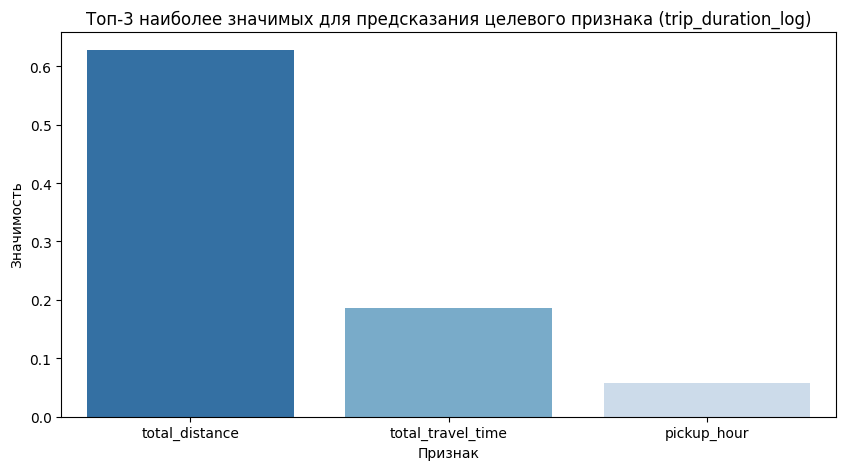

In [48]:
# Выделяем значимость признаков из обученной модели
feature_importance = gbr_model.feature_importances_

# Cоздаем на его основе датасет 
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importance
})

# Сортируем по значимости
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(3)

# Создаем фигуру для графика
fig, axes = plt.subplots(figsize=(10, 5))

# Строим столбчатую диаграмму (barplot)
sns.barplot(
    data=feature_importance_df,
    x='Feature',
    y='Importance',
    palette='Blues_r',
    ax=axes
)

# Устанавливаем заголовок и подписи осей
axes.set_title('Топ-3 наиболее значимых для предсказания целевого признака (trip_duration_log)')
axes.set(xlabel='Признак', ylabel='Значимость')

# Отображаем график
plt.show()

Примечание: 

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой! Нам хотелось бы понять, насколько итоговая модель хорошо предсказывает целевой признак с точки зрения бизнес-процесса. Точнее, хотелось бы получить более понятное представление об ошибке прогноза длительности поездки.

### 6.5.

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:

$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.

In [49]:
# Переводим метрики обратно из логарифмического масштаб
y_valid = np.exp(y_valid_log)-1
y_valid_pred = np.exp(valid_pred)-1

# Рассчитываем на влидационной выборке MEAE в cекундах
meae_valid_sec = metrics.median_absolute_error(y_valid, y_valid_pred)

# Выводим результаты
print(f'Метрика MEAE для валидационной выборке (секунды): {round(meae_valid_sec, 1)}')
print(f'Метрика MEAE для валидационной выборке (минуты): {round(meae_valid_sec / 60, 1)}')

Метрика MEAE для валидационной выборке (секунды): 109.8
Метрика MEAE для валидационной выборке (минуты): 1.8


Теперь сделаем финальный шаг - submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. 

Он еще пригодится:

In [ ]:
test_data = pd.read_csv("Data/test.csv")
osrm_data_test = pd.read_csv("Data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые производились с тренировочной выборкой, а именно:

* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.

In [55]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)

# Приводим 'pickup_date' в test_data к формату date (без времени)
test_data['pickup_date'] = pd.to_datetime(test_data['pickup_date']).dt.date
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)

print('Shape of data: {}'.format(X_test.shape))

/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. 

Переведем признак предсказания из логарифмического масштаба в истинный, используя формулу:

$$y_i=exp(z_i)-1$$

После того, как сформируем предсказание длительности поездок на тестовой выборке необходимо будет создать submission-файл в формате csv и отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

In [56]:
# Прогнозирование
test_predict = gbr_model.predict(X_test_scaled)
y_test_predict = np.exp(test_predict)-1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('Data/submission.csv', index=False)

/Users/alexander/Desktop/Regression_Task_Project/.venv/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [57]:
my_submission = pd.read_csv('Data/submission.csv')
display(my_submission)

,id,trip_duration
0,id3004672,877.596163
1,id3505355,516.824939
2,id1217141,408.435989
3,id2150126,1026.909929
4,id1598245,248.624592
...,...,...
625129,id3008929,360.028686
625130,id3700764,1281.342243
625131,id2568735,1668.590098
625132,id1384355,1934.469591


## 7. Дополнительно

В завершение по ансамблевым можно попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [58]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [59]:
feature_names = list(selected_features)  # Преобразуем Index в список строк

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [60]:
# Гиперпараметры модели
xgb_pars = {
    'min_child_weight': 20, 
    'eta': 0.1, 
    'colsample_bytree': 0.9, 
    'max_depth': 6, 
    'subsample': 0.9, 
    'lambda': 1, 
    'nthread': -1, 
    'booster' : 'gbtree', 
    'eval_metric': 'rmse', 
    'objective': 'reg:squarederror'
}

# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, # гиперпараметры модели
    dtrain=dtrain, # обучающая выборка
    num_boost_round=300, # количество моделей в ансамбле
    evals=watchlist, # выборки, на которых считается матрица
    early_stopping_rounds=20, # раняя остановка
    maximize=False, # смена поиска максимума на минимум
    verbose_eval=10 # шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74154	valid-rmse:0.74355
[10]	train-rmse:0.49215	valid-rmse:0.49478
[20]	train-rmse:0.43972	valid-rmse:0.44263
[30]	train-rmse:0.42542	valid-rmse:0.42854
[40]	train-rmse:0.41785	valid-rmse:0.42123
[50]	train-rmse:0.41259	valid-rmse:0.41629
[60]	train-rmse:0.40810	valid-rmse:0.41210
[70]	train-rmse:0.40572	valid-rmse:0.41002
[80]	train-rmse:0.40307	valid-rmse:0.40768
[90]	train-rmse:0.40144	valid-rmse:0.40635
[100]	train-rmse:0.39954	valid-rmse:0.40467
[110]	train-rmse:0.39775	valid-rmse:0.40311
[120]	train-rmse:0.39658	valid-rmse:0.40225
[130]	train-rmse:0.39550	valid-rmse:0.40142
[140]	train-rmse:0.39459	valid-rmse:0.40084
[150]	train-rmse:0.39332	valid-rmse:0.39979
[160]	train-rmse:0.39198	valid-rmse:0.39879
[170]	train-rmse:0.39098	valid-rmse:0.39812
[180]	train-rmse:0.39024	valid-rmse:0.39768
[190]	train-rmse:0.38943	valid-rmse:0.39718
[200]	train-rmse:0.38884	valid-rmse:0.39692
[210]	train-rmse:0.38820	valid-rmse:0.39653
[220]	train-rmse:0.38742	valid-rmse:0.39602

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [61]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1

print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39378


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

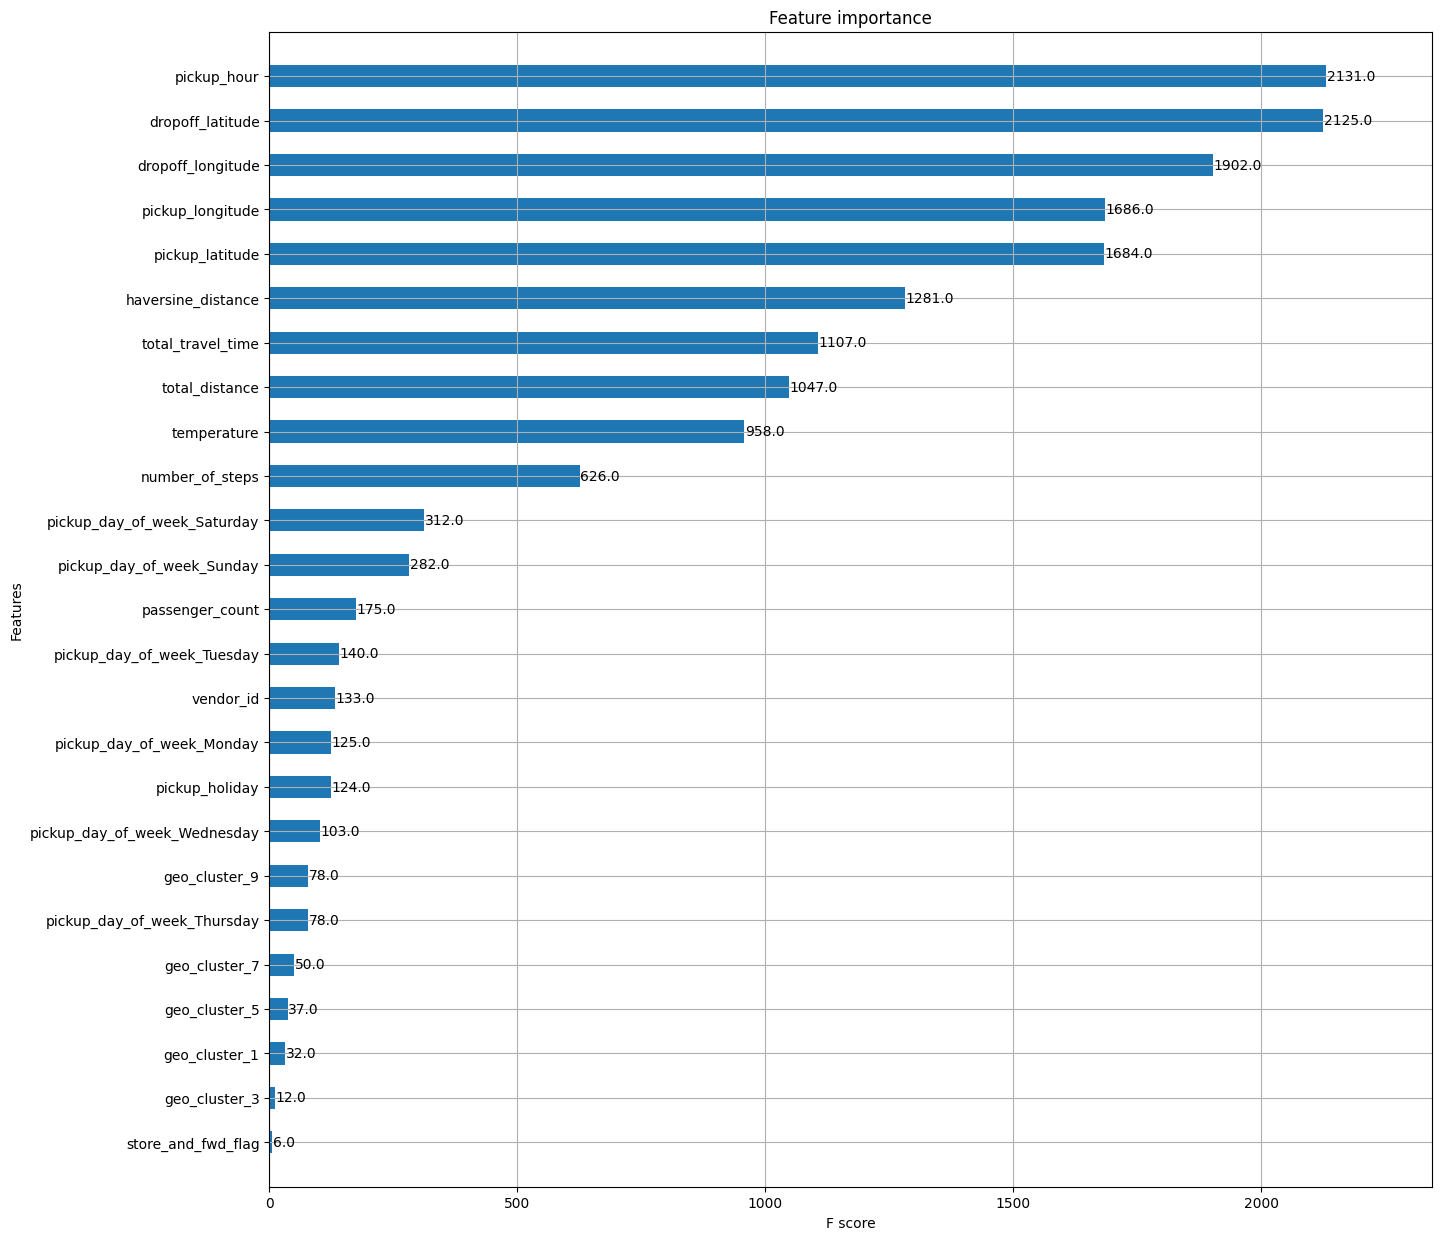

In [62]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)